# Function fiting
With a single-qunit classifier and a single-qutrit classifier

In [1]:
# Import everything we need
import numpy as np
import matplotlib.pyplot as plt
from scipy import special
from sklearn.utils import shuffle


#optimization method
from scipy.optimize import minimize

#gradient obtaining
from scipy.optimize import rosen, rosen_der
from scipy.optimize.optimize import approx_fprime

In [121]:
class fitting_qutrits: 
    def __init__(self, layers, f_type, ansatz, coeffs = None,num_samples= 400, seed = 7):
        """Class that includes all the necessary for the fiting problem with one qutrit
        
        Args: 
            - f_type (str): Type of function generated 
                                ['Fourier', 'Bessel'].
            - qubits (int): Number of qubits.
            - layers(int): Number of layers that our circuit ansatz will have. 
            - ansatz(str): Options. 
                            -D1: Trainable gate: Ry01(p1)Rz02(p2)Ry02(p3)Rz01(p4). Encoding Rz(01)(x)Rz(02)(-x)
                            -D1w: Trainable gate: Ry01(p1)Rz02(p2)Ry02(p3)Rz01(p4). Encoding Rz(01)(p5x)Rz(02)(-p6x)
            - coeffs (array): Coefficients of the Fourier serie
            - num_samples (int): Number of data-points. Half are used for the training and half the testing set.
            - seed (int): Random seed


        Returns: 
            - Training set and test set (array: (x,y)).
                    - x (array): domain of the function
                    - y (int): value of the function
            - Params (array): initial random parameters for the circuit. 
            """
        np.random.seed(seed)
        self.layers = layers 
        self.coeffs = coeffs
        self.num_samples = num_samples
        self.f_type = f_type
        self.ansatz = ansatz
        if self.f_type == 'Fourier':
            x_data = shuffle(np.linspace(-5,5,self.num_samples))
            self.xtrain = np.sort(x_data[:int(self.num_samples/2)])
            self.xtest = np.sort(x_data[int(self.num_samples/2):])
            self.function_train = np.array([self.funct(x_) for x_ in self.xtrain])
            self.function_test = np.array([self.funct(x_) for x_ in self.xtest])
        elif self.f_type == 'Bessel':
            self.x_data = shuffle(np.linspace(0,20,self.num_samples))
            self.xtrain = np.sort(self.x_data[:int(self.num_samples/2)])
            self.xtest = np.sort(self.x_data[int(self.num_samples/2):])
            self.function = self.funct(np.sort(self.x_data))
            self.function_train= self.funct(self.xtrain)
            self.function_test = self.funct(self.xtest)
        if self.ansatz =='D1':
            self.npars = 4
        elif self.ansatz == 'D1w': 
            self.npars = 6
        else: 
            print('error')
        self.params = np.random.uniform(size=(self.layers+1, self.npars))
        self.layers_param = []



    def funct(self, x,scaling=1):
        """Generate a truncated Fourier (with a re-scaling) series or a Bessel series.
        
        Args: 
         -x: data point or array
         -f_type (str): Fourier or Bessel
        Returns:
        -y: Value of the function at x"""

        if self.f_type== 'Fourier':
            coeffs = self.coeffs
            res = 0
            for idx, coeff in enumerate(coeffs):
                exponent = np.complex(0, scaling*(idx)*x)
                conj_coeff = np.conjugate(coeff)
                res += 3*(coeff * np.exp(exponent) + conj_coeff * np.exp(-exponent))/5
            return np.real(res)
        elif self.f_type == 'Bessel':
            y = special.jv(2, x)
            return y

    def gates(name, param = None): 
        """
        This function implements the diferents gates for qutrits that we are going to use in the circuit

         Args:
            name (str): Name of the gate

        Returns:
            gate (array): quantum gate
         """

        j = 1j
        pi = np.pi
        if name == 'Ry_01':
            gate = np.array([[np.cos(param/2),np.sin(param/2), 0], 
                            [-np.sin(param/2), np.cos(param/2), 0], 
                            [0,0,1]], dtype='complex')
        elif name == 'Ry_02': 
            gate = np.array([[np.cos(param/2),0,np.sin(param/2)],
                            [0,1,0],
                            [-np.sin(param/2),0, np.cos(param/2)]], dtype='complex')
        elif name == 'Rz_01': 
            gate = np.array([[np.exp(j*param/2),0,0],[0,np.exp(-j*param/2),0], [0,0,1] ], dtype='complex')
        elif name == 'Rz_02': 
            gate = np.array([[np.exp(j*param/2),0,0],[0,1,0], [0,0,np.exp(-j*param/2)] ], dtype='complex')
        elif name == 'lambda_3': 
            gate = np.array([[1,0,0],[0,-1,0], [0,0,0]], dtype='complex')
        elif name == 'lambda_8': 
            gate = (1/np.sqrt(3))*np.array([[1,0,0],[0,1,0], [0,0,-2] ], dtype='complex')
        elif name == 'Rz(3)': 
            gate = np.array([[1,0,0],
                            [0,np.exp(j*2*pi*param/3),0], 
                            [0,0,np.exp(-j*2*pi*param/3)]], dtype='complex')
        return gate

    def general_unitary(self, angles):
        """ 
        General unitary of a qutrit. 
        
        Args: 
        - angles: array of lengy 8

        Returns: 
        - unitary: parameterized quantum gate
        """

        unitary = np.dot(fitting_qutrits.gates('Ry_01', param= angles[0]), fitting_qutrits.gates('Ry_02', param= angles[1]))
        unitary = np.dot(unitary, fitting_qutrits.gates('Ry_01', param= angles[2]))
        unitary = np.dot(unitary, fitting_qutrits.gates('Rz_01', param= angles[3]))
        unitary = np.dot(unitary, fitting_qutrits.gates('Rz_02', param= angles[4]))
        unitary = np.dot(unitary, fitting_qutrits.gates('Ry_01', param= angles[5]))
        unitary = np.dot(unitary,fitting_qutrits.gates('Ry_02', param= angles[6]))
        unitary = np.dot(unitary,fitting_qutrits.gates('Ry_01', param= angles[7]))
        return unitary 

    def circuit(self, x, initial_state = None): 
        """
        This function simulates the quantum circuit of a qutrit
        INPUTS: 
        - x (array): single data-point of the problem. 
        OUTPUT: 
        - state (array): quantum state after the application of the unitaries that form the circuit ansatz"""
        if initial_state == None: 
            initial_state = np.array([1,0,0], dtype='complex')
        params = self.params
        state = initial_state


        state = np.dot(fitting_qutrits.gates('Ry_01', params[0][0]), state)
        state = np.dot(fitting_qutrits.gates('Rz_02', params[0][1]), state)
        state = np.dot(fitting_qutrits.gates('Ry_02', params[0][2]), state)
        state = np.dot(fitting_qutrits.gates('Rz_01', params[0][3]), state)
        
        if self.ansatz == 'D1':
            for p in params[1:]:
                #Encoding
                state = np.dot(fitting_qutrits.gates('Rz_01', x), state)
                state = np.dot(fitting_qutrits.gates('Rz_02', -x), state)
                #Trainable gates
                state = np.dot(fitting_qutrits.gates('Ry_01', p[0]), state)
                state = np.dot(fitting_qutrits.gates('Rz_02', p[1]), state)
                state = np.dot(fitting_qutrits.gates('Ry_02', p[2]), state)
                state = np.dot(fitting_qutrits.gates('Rz_01', p[3]), state)

        elif self.ansatz == 'D1w':
            for p in params[1:]:
                #Encoding
                state = np.dot(fitting_qutrits.gates('Rz_01', p[0]*x), state)
                state = np.dot(fitting_qutrits.gates('Rz_02', -p[1]*x), state)
                #Trainable gates
                state = np.dot(fitting_qutrits.gates('Ry_01', p[2]), state)
                state = np.dot(fitting_qutrits.gates('Rz_02', p[3]), state)
                state = np.dot(fitting_qutrits.gates('Ry_02', p[4]), state)
                state = np.dot(fitting_qutrits.gates('Rz_01', p[5]), state)
                    


        #TZ:
        # observable = fitting_qutrits.gates('lambda_3')
        #Uz:
        observable = (-fitting_qutrits.gates('lambda_3')+np.sqrt(3)*fitting_qutrits.gates('lambda_8'))/2
        #Vz: 
        # observable = (fitting_qutrits.gates('lambda_3')+np.sqrt(3)*fitting_qutrits.gates('lambda_8'))/2
        expval = np.dot(np.conjugate(state.T), np.dot(observable, state))
        return np.real(expval)

    def cost_function(self, params = None):
        """
       Cost function consisting on the squared difference between the function output for the circuit (expceted value) and the real value of 
       the function. It is averaged aver all training points.

        Args: 
        -params: The params will be updated after each step of the minimization method. 
        Returns: 
        - Value of the cost function.
        """
        if params is not None:
            self.params = params.reshape(self.layers+1,self.npars)
        loss = 0.0
        for x,y in zip(self.xtrain, self.function_train):
            y_pred = self.circuit(x)
            loss += (y-y_pred)**2
        loss /= len(self.xtrain)
        return loss

    def minimize_funct(self,method='bfgs', options=None, compile = True):
        """"
        This function minimizes the cost function in the space of the parameters. Then 
        it returns the value of the function when the optimization has finished and the 
        values of the parameters that acomplish the desired optimization.
        
        Args: 
        - method (str): minimization method used.
        - params (array): randomly initial parameters. They are updated at each opitmization step.
        
        Returns: 
        - Optimal params (array)
        - Value of the cost function when the minimization is over.   """

        exact = []
        approx = []
        def callback(x):
           exact.append(rosen_der(x))
           approx.append(approx_fprime(x, rosen, 1E-8))

        m = minimize(lambda p: self.cost_function(p), x0 = self.params, method=method, 
                            options=options, callback=callback)
        result = m.fun

        #x: solution of the optimization
        parameters = m.x
        return result, parameters, exact, approx


    def plot_data(self, params_opt, fig = None):
        """

        Args:
            x (array[tuple]): array of data points as tuples
            y (array[int]): array of data points as tuples
        """
        y_pred = []
        SSE= 0
        SST = 0
        
        average =sum(self.function_test)/(self.num_samples/2)
        self.params = params_opt.reshape((self.layers+1,self.npars))
        for x,y_real in zip(self.xtest, self.function_test): 
            y_pred_x = self.circuit(x)
            y_pred.append(y_pred_x)
            SSE += (y_real- y_pred_x)**2
            SST +=(y_real-average)**2
        R = 1- SSE/SST
        

        # print(R)
       
        


        # if fig == None:
        #     fig, ax = plt.subplots(1, 1, figsize=(5, 5))
        
        # if self.layers ==1:
        ax.plot(np.sort(self.x_data), self.function, label= 'Bessel', c = 'c' )
        ax.scatter(self.xtest, y_pred, label= 'Params= ' + str(self.layers*self.npars+4), s= 24, marker = 'x')
        ax.legend(loc='upper right', prop= {'size':15})
        ax.set_xlabel("$x$", fontsize = 15)
        ax.set_ylabel("$f(x)$", fontsize = 15)
        plt.xticks(fontsize=15)
        plt.yticks(fontsize = 15)
        ax.set_yticks([ -0.4, -0.2, 0, 0.2, 0.4])
        # ax.set_xticklabels( Fontsize= 10) 
        # ax.set_xticklabels([float(x) for x in range(0,20, 2)],fontsize =15)
        print('accuracy: ', R*100, '%')
        return self.xtest, y_pred

In [127]:
# Parameters for functions

class fitting_qubits: 
    def __init__(self, layers,ansatz, qubits, f_type, coeffs = None, num_samples= 400, seed = 7):
        """Class that includes all the necessary for the fiting problem with one qubit
        
        Args: 
            - f_type (str): Type of function generated 
                                ['Fourier', 'Bessel'].
            - qubits (int): Number of qubits.
            - layers(int): Number of layers that our circuit ansatz will have. 
            - ansatz(int): Options. 
                            -1: Trainable gate: Ry(p1). Encoding gate: Rz(x)
                            -2: Trainable gate: Ry(p1)Rz(p2). Encoding gate: Rz(x)
                            -3: Trainable gate: Ry(p1)Rz(p2). Encoding gate: Rz(p3x)
            - coeffs (array): Coefficients of the Fourier serie
            - num_samples (int): Number of data-points. Half are used for the training and half the testing set.
            - seed (int): Random seed


        Returns: 
            - Training set and test set (array: (x,y)).
                    - x (array): domain of the function
                    - y (int): value of the function
            - Params (array): initial random parameters for the circuit. 
            """

        np.random.seed(seed)
        self.layers = layers 
        self.coeffs = coeffs
        self.qubits = qubits
        self.f_type = f_type
        self.num_samples = num_samples

        if self.f_type == 'Fourier':
            self.x_data = shuffle(np.linspace(-5,5,self.num_samples))
            self.xtrain = np.sort(self.x_data[:int(self.num_samples/2)])
            self.xtest = np.sort(self.x_data[int(self.num_samples/2):])
            self.function = np.array([self.funct(x_) for x_ in np.sort(self.x_data)])
            self.function_train = np.array([self.funct(x_) for x_ in self.xtrain])
            self.function_test = np.array([self.funct(x_) for x_ in self.xtest])

        elif self.f_type == 'Bessel':
            self.x_data = shuffle(np.linspace(0,20,self.num_samples))
            self.xtrain = np.sort(self.x_data[:int(self.num_samples/2)])
            self.xtest = np.sort(self.x_data[int(self.num_samples/2):])
            self.function = self.funct(np.sort(self.x_data))
            self.function_train= self.funct(self.xtrain)
            self.function_test = self.funct(self.xtest)


        self.ansatz = ansatz
        self.params = np.random.uniform(size=(self.layers+1, self.ansatz))
        self.layers_param = []



    def funct(self, x, scaling=1):
        """
        Generate a truncated Fourier (with a re-scaling) series or a Bessel series.
        
        Args: 
         -x: data point or array
         -f_type (str): Fourier or Bessel
        Returns:
        -y: Value of the function at x """
        if self.f_type== 'Fourier':
            coeffs = self.coeffs
            res = 0
            for idx, coeff in enumerate(coeffs):
                exponent = np.complex(0, scaling*(idx)*x)
                conj_coeff = np.conjugate(coeff)
                res += 3*(coeff * np.exp(exponent) + conj_coeff * np.exp(-exponent))/5
            return np.real(res)
        elif self.f_type == 'Bessel':
            y = special.jv(2, x)
            return y


    def gates(name, param): 
        """
        This function implements the diferents gates for qubits that we are going to use in the circuit

         Args:
            name (str): Name of the gate

        Returns:
            gate (array): quantum gate
         """
        j = 1j
        if name == 'Ry':
            gate = np.array([[np.cos(param/2),np.sin(param/2)], [-np.sin(param/2), np.cos(param/2)]], dtype='complex')
        elif name == 'Rz': 
            gate = np.array([[np.exp(j*param/2),0],[0,np.exp(-j*param/2)] ], dtype='complex')
        elif name == 'Rx':
            gate = np.array([[np.cos(param/2),-j*np.sin(param/2)], [-j*np.sin(param/2), np.cos(param/2)]], dtype='complex')
        return gate



    def circuit(self, x, initial_state = None): 
        """This function simulates the quantum circuit of a qubit
        INPUTS: 
        - x (array): single data-point of the problem. 
        OUTPUT: 
        - expval (float): Expected value of the pauli-Z observable after the state in the PQC. """
        if initial_state == None: 
            initial_state = np.array([1,0], dtype='complex')
        params = self.params
        state = initial_state 

        if self.ansatz ==1: 
            state = np.dot(fitting_qubits.gates('Ry', params[0][0]), state)
            for p in params[1:]:
                #Encoding
                state = np.dot(fitting_qubits.gates('Rz', x), state)
                #params
                state = np.dot(fitting_qubits.gates('Ry', p[0]), state)

        
        
        elif self.ansatz ==2: 
            state = np.dot(fitting_qubits.gates('Ry', params[0][0]), state)
            state = np.dot(fitting_qubits.gates('Rz', params[0][1]), state)
            for p in params[1:]:
                #Encoding
                state = np.dot(fitting_qubits.gates('Rz', x), state)
                #params
                state = np.dot(fitting_qubits.gates('Ry', p[0]), state)
                state = np.dot(fitting_qubits.gates('Rz', p[1]), state)

        elif self.ansatz ==3: 
            state = np.dot(fitting_qubits.gates('Ry', params[0][0]), state)
            state = np.dot(fitting_qubits.gates('Rz', params[0][1]), state)
            for p in params[1:]:
                #Encoding
                state = np.dot(fitting_qubits.gates('Rz', p[0]*x), state)
                #Params
                state = np.dot(fitting_qubits.gates('Ry', p[1]), state)
                state = np.dot(fitting_qubits.gates('Rz', p[2]), state)


        expval = np.abs(state[0])**2-np.abs(state[1])**2
        return expval

    def cost_function(self, params = None):
        """
       Cost function consisting on the squared difference between the function output for the circuit (expceted value) and the real value of 
       the function. It is averaged aver all training points.

        Args: 
        -params: The params will be updated after each step of the minimization method. 
        Returns: 
        - Value of the cost function."""

        if params is not None:
            self.params = params.reshape(self.layers+1,self.ansatz)
        loss = 0.0
        for x,y in zip(self.xtrain, self.function_train):
            y_pred = self.circuit(x)
            loss += (y-y_pred)**2
        loss /= len(self.xtrain)
        # print(loss, 'loss')
        return loss

    def minimize_funct(self,method='bfgs', options=None, compile = True):
        """"
       Minimization of the cost function in the space of the parameters. Then 
        it returns the value of the function when the optimization has finished and the 
        values of the parameters that acomplish the desired optimization."""



        exact = []
        approx = []
        def callback(x):
           exact.append(rosen_der(x))
           self.layers_param.append(self.params)
           approx.append(approx_fprime(x, rosen, 1E-8))
        

        m = minimize(lambda p: self.cost_function(p), x0 = self.params, method=method, 
                            options=options, callback=callback)
        result = m.fun

        #x: solution of the optimization
        parameters = m.x
        return result, parameters, exact, approx
       # return result, parameters, exact, approx #pred_params


    def plot_data(self, params_opt, fig = None):
        """

        Args:
            x (array[tuple]): array of data points as tuples
            y (array[int]): array of data points as tuples
            params_opt (array): params after the optimization
        """
        y_pred = []
        
        self.params = params_opt.reshape(self.layers+1,self.ansatz)

        
        SSE= 0
        SST = 0
        average =sum(self.function_test)/(self.num_samples/2)





        for x,y_real in zip(self.xtest, self.function_test): 
            y_pred_x = self.circuit(x)
            y_pred.append(y_pred_x)
            SSE += (y_real- y_pred_x)**2
            SST +=(y_real-average)**2
        R = 1- SSE/SST

        if self.layers==1:
            ax.plot(np.sort(self.x_data),self.function, label= str(self.f_type), c = 'c', linewidth= 2 )
        ax.scatter(self.xtest, y_pred, label= 'Layers: ' +str(self.layers), s= 17, marker= 'x')
        ax.legend(loc='upper right', prop= {'size':17})
        ax.set_xlabel("$x$", fontsize = 17)
        ax.set_ylabel("$f(x)$", fontsize = 17)
        plt.xticks(fontsize=17)
        plt.yticks(fontsize = 17)
        print('accuracy: ', R*100, '%')

    




accuracy:  99.50260499680572 %


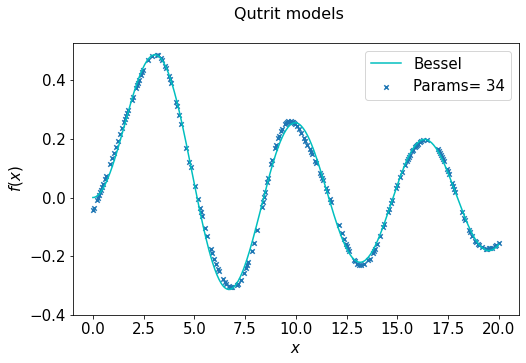

In [104]:

coeffs = [0.4, 0.15+0.15j, 0.15-0.15j, -0.15+0.15j]
layer = 5
qutrit_fitting = fitting_qutrits(layers = layer, f_type = 'Bessel',  ansatz='D1w')
resultat, parametres_d1w, aa,bb = qutrit_fitting.minimize_funct(method='NELDER-MEAD', 
     options={'disp': True}, compile= True)
fig, ax = plt.subplots(1, 1, figsize = (8,5))
y5,x5 = qutrit_fitting.plot_data(params_opt= parametres_d1w)

accuracy:  28.354256821507718 %
accuracy:  29.27755339363817 %
accuracy:  64.47525862896485 %
accuracy:  92.61331266059975 %


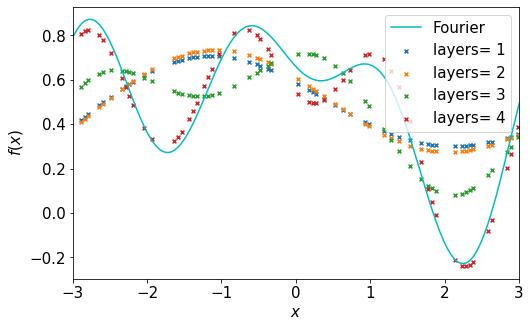

In [36]:
coeffs = [0.4, 0.15+0.15j, 0.15-0.15j, -0.15+0.15j]
layer_test = [x for x in range(1,7)]
qutrit_fit = []
for layer in layer_test:
    qutrit_fit.append(fitting_qutrits(layers = layer, coeffs = coeffs, f_type = 'Fourier', ansatz = 'D1'))


opt_params = [0]*len(layer_test)




for i in range(len(layer_test)):
    _, opt_params[i],_,_ = qutrit_fit[i].minimize_funct(method='Nelder-Mead', 
                                                              options={'disp': True}, compile= True)


fig, ax = plt.subplots(1, 1, figsize = (8,5))
for i in range(len(layer_test)-2):
    qutrit_fit[i].plot_data(params_opt= opt_params[i])

accuracy:  31.530331804759125 %
accuracy:  70.57146775376997 %
accuracy:  99.99999986106636 %


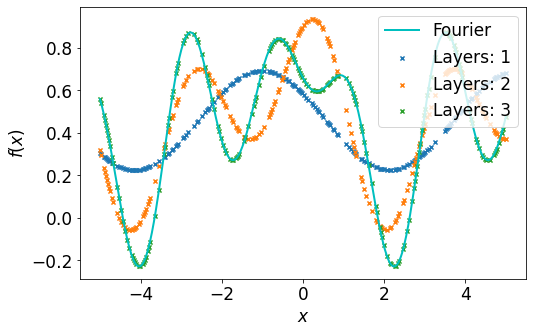

In [128]:
#Ansatz 2 Qubits
coeffs = [0.4, 0.15+0.15j, 0.15-0.15j, -0.15+0.15j]
layer_test = [1,2,3]
qubit_fit = []
for layer in layer_test:
    qubit_fit.append(fitting_qubits(layers = layer, coeffs = coeffs, ansatz=2, qubits=1, f_type = 'Fourier'))


opt_params_qubit = [0]*len(layer_test)
# L-BFGS-B
for i in range(len(layer_test)):
   _,opt_params_qubit[i], _,_ = qubit_fit[i].minimize_funct(method='NELDER-MEAD', 
    options={'disp': True}, compile= True)
fig, ax = plt.subplots(1, 1, figsize = (8,5))
for i in range(len(opt_params_qubit)):
    qubit_fit[i].plot_data(params_opt=opt_params_qubit[i])
